In [1]:
# %%
# ==========================================
# 1. Importación de librerías
# ==========================================
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.model_selection import train_test_split
import tensorflow as tf

# Configuraciones generales
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8')

In [2]:
# %%
# ==========================================
# 2. Cargar el dataset CSV
# ==========================================
CSV_PATH = '/content/drive/MyDrive/Maestría Eafit/3er Semestre/Visión por computador/Talleres/data/Data Aviones/Airplanes.csv'
IMAGES_DIR = '/content/drive/MyDrive/Maestría Eafit/3er Semestre/Visión por computador/Talleres/data/Data Aviones/airplanes/airplanes'

try:
    df = pd.read_csv(CSV_PATH)
    print("✅ Dataset cargado correctamente.")
except FileNotFoundError:
    raise FileNotFoundError(f"❌ No se encontró el archivo CSV en {CSV_PATH}. Verifica la ruta.")

print(f"\nNúmero total de registros: {len(df)}")
df.head()


✅ Dataset cargado correctamente.

Número total de registros: 800


,Unnamed: 0,Image,y_top,y_bottom,x_top,x_bottom,label
0,0,image_0001.jpg,30,137,49,349,Airplanes
1,0,image_0002.jpg,35,153,59,342,Airplanes
2,0,image_0003.jpg,36,135,47,331,Airplanes
3,0,image_0004.jpg,24,141,47,342,Airplanes
4,0,image_0005.jpg,18,146,48,339,Airplanes



Información general del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  800 non-null    int64 
 1   Image       800 non-null    object
 2   y_top       800 non-null    int64 
 3   y_bottom    800 non-null    int64 
 4   x_top       800 non-null    int64 
 5   x_bottom    800 non-null    int64 
 6   label       800 non-null    object
dtypes: int64(5), object(2)
memory usage: 43.9+ KB
None

Valores nulos por columna:
Unnamed: 0    0
Image         0
y_top         0
y_bottom      0
x_top         0
x_bottom      0
label         0
dtype: int64


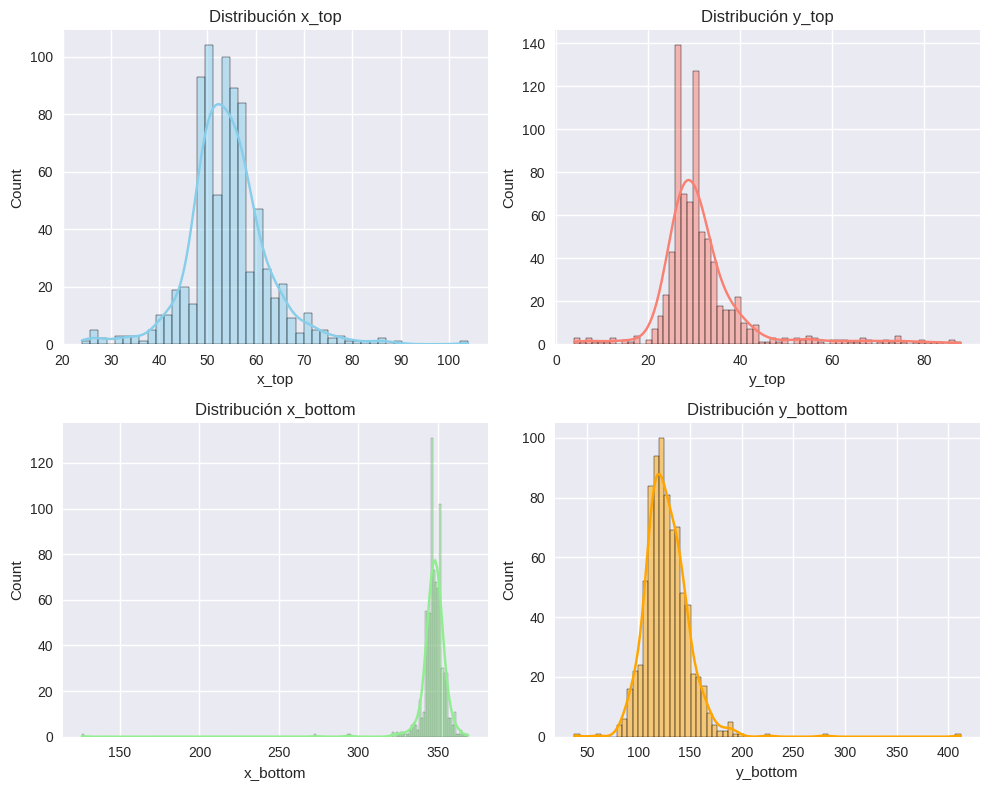

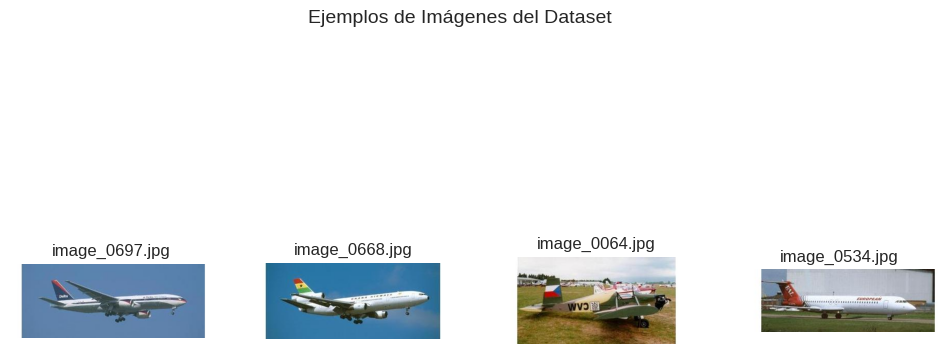

In [3]:
# %%
# ==========================================
# 3. Exploratory Data Analysis (EDA)
# ==========================================

print("\nInformación general del dataset:")
print(df.info())

print("\nValores nulos por columna:")
print(df.isnull().sum())

# Visualizar distribución de coordenadas
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
sns.histplot(df['x_top'], kde=True, ax=axes[0,0], color='skyblue')
axes[0,0].set_title('Distribución x_top')

sns.histplot(df['y_top'], kde=True, ax=axes[0,1], color='salmon')
axes[0,1].set_title('Distribución y_top')

sns.histplot(df['x_bottom'], kde=True, ax=axes[1,0], color='lightgreen')
axes[1,0].set_title('Distribución x_bottom')

sns.histplot(df['y_bottom'], kde=True, ax=axes[1,1], color='orange')
axes[1,1].set_title('Distribución y_bottom')

plt.tight_layout()
plt.show()

# Mostrar una muestra de imágenes
sample_imgs = df.sample(4, random_state=42)['Image']
plt.figure(figsize=(12, 6))
for i, img_name in enumerate(sample_imgs):
    path = os.path.join(IMAGES_DIR, img_name)
    if os.path.exists(path):
        img = Image.open(path)
        plt.subplot(1, 4, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(img_name)
plt.suptitle("Ejemplos de Imágenes del Dataset", fontsize=14)
plt.show()


In [4]:
# %%
# ==========================================
# 4. Normalización de coordenadas
# ==========================================
normalized_x_top, normalized_y_top = [], []
normalized_x_bottom, normalized_y_bottom = [], []

print(f"\n🔄 Iniciando procesamiento de {len(df)} imágenes...")

for _, row in df.iterrows():
    image_name = row['Image']
    image_path = os.path.join(IMAGES_DIR, image_name)

    try:
        img = Image.open(image_path)
        W, H = img.size
    except FileNotFoundError:
        print(f"⚠️ Imagen no encontrada: {image_path}")
        normalized_x_top.append(None)
        normalized_y_top.append(None)
        normalized_x_bottom.append(None)
        normalized_y_bottom.append(None)
        continue

    # Normalización de coordenadas
    normalized_x_top.append(row['x_top'] / W)
    normalized_y_top.append(row['y_top'] / H)
    normalized_x_bottom.append(row['x_bottom'] / W)
    normalized_y_bottom.append(row['y_bottom'] / H)

# Agregar columnas al dataframe
df['n_x_top'] = normalized_x_top
df['n_y_top'] = normalized_y_top
df['n_x_bottom'] = normalized_x_bottom
df['n_y_bottom'] = normalized_y_bottom

print("\n✅ Normalización completa. Vista previa del dataset:")
df.head()



🔄 Iniciando procesamiento de 800 imágenes...

✅ Normalización completa. Vista previa del dataset:


,Unnamed: 0,Image,y_top,y_bottom,x_top,x_bottom,label,n_x_top,n_y_top,n_x_bottom,n_y_bottom
0,0,image_0001.jpg,30,137,49,349,Airplanes,0.123116,0.182927,0.876884,0.835366
1,0,image_0002.jpg,35,153,59,342,Airplanes,0.147132,0.190217,0.852868,0.831522
2,0,image_0003.jpg,36,135,47,331,Airplanes,0.119593,0.218182,0.842239,0.818182
3,0,image_0004.jpg,24,141,47,342,Airplanes,0.119593,0.141176,0.870229,0.829412
4,0,image_0005.jpg,18,146,48,339,Airplanes,0.121519,0.102273,0.858228,0.829545


In [5]:
# %%
# ==========================================
# 5. Preparación de imágenes y etiquetas
# ==========================================
IMG_SIZE = 224
images, targets = [], []

print("\n📦 Cargando y preprocesando imágenes...")

for _, row in df.dropna().iterrows():
    img_path = os.path.join(IMAGES_DIR, row['Image'])
    image = load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    image = img_to_array(image) / 255.0

    label = [row['n_x_top'], row['n_y_top'], row['n_x_bottom'], row['n_y_bottom']]
    images.append(image)
    targets.append(label)

X = np.array(images, dtype="float32")
Y = np.array(targets, dtype="float32")

trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.2, random_state=42)

print(f"✅ Conjunto de entrenamiento: {trainX.shape}")
print(f"✅ Conjunto de prueba: {testX.shape}")



📦 Cargando y preprocesando imágenes...
✅ Conjunto de entrenamiento: (640, 224, 224, 3)
✅ Conjunto de prueba: (160, 224, 224, 3)


In [6]:
# %%
# ==========================================
# 6. Definición y compilación del modelo CNN
# ==========================================
def build_cnn_model(input_shape):
    model = Sequential([
        Conv2D(16, (3, 3), padding="same", activation="relu", input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(32, (3, 3), padding="same", activation="relu"),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), padding="same", activation="relu"),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation="relu"),
        Dense(4, activation="sigmoid", name="bounding_box_output")
    ])
    return model

input_shape = (IMG_SIZE, IMG_SIZE, 3)
model = build_cnn_model(input_shape)
model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(1e-4))

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     6,422,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bounding_box_output (Dense)     │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,446,756 (24.59 MB)

 Trainable params: 6,446,756 (24.59 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# %%
# ==========================================
# 7. Entrenamiento del modelo
# ==========================================
EPOCHS = 50
BATCH_SIZE = 32

print("\n🏋️ Entrenando el modelo...")

H = model.fit(
    trainX, trainY,
    validation_data=(testX, testY),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

print("\n✅ Entrenamiento finalizado.")



🏋️ Entrenando el modelo...
Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - loss: 0.0295 - val_loss: 0.0067
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - loss: 0.0048 - val_loss: 0.0019
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - loss: 0.0019 - val_loss: 0.0015
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - loss: 0.0018 - val_loss: 0.0013
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - loss: 0.0017 - val_loss: 0.0012
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - loss: 0.0011 - val_loss: 0.0011
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - loss: 0.0011 - val_loss: 0.0010
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - loss: 0.0011 - val_loss: 0.0010
Epoch 9/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - loss: 0.0013 - val_loss: 9.5625e-04
Epoch 10/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - loss: 7.5951e-04 - val_loss: 9.5058e-04
Epoch 11/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - loss: 7.3172e-04 - val_loss: 8.8321e-04
Epoch 12/50
20/20 ━━━━━━━━

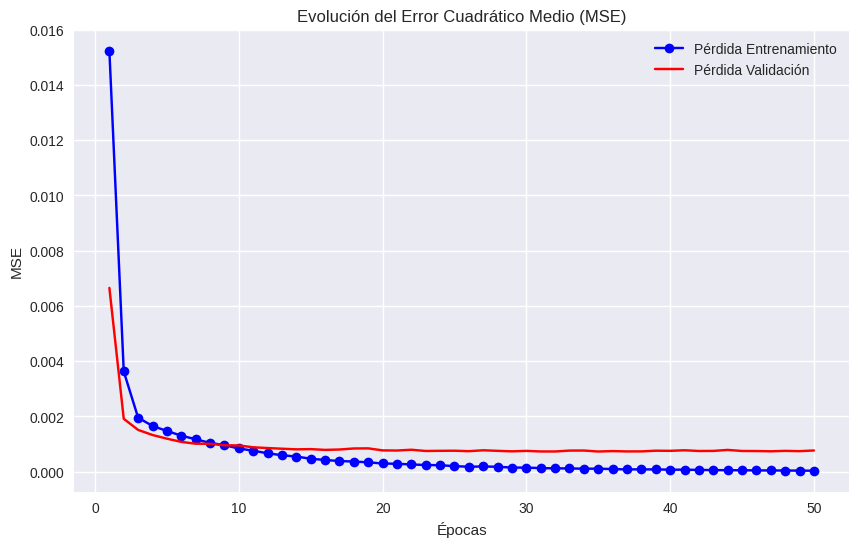

In [8]:
# %%
# ==========================================
# 8. Curva de pérdida
# ==========================================
loss, val_loss = H.history['loss'], H.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, 'bo-', label='Pérdida Entrenamiento')
plt.plot(epochs, val_loss, 'r-', label='Pérdida Validación')
plt.title('Evolución del Error Cuadrático Medio (MSE)')
plt.xlabel('Épocas')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


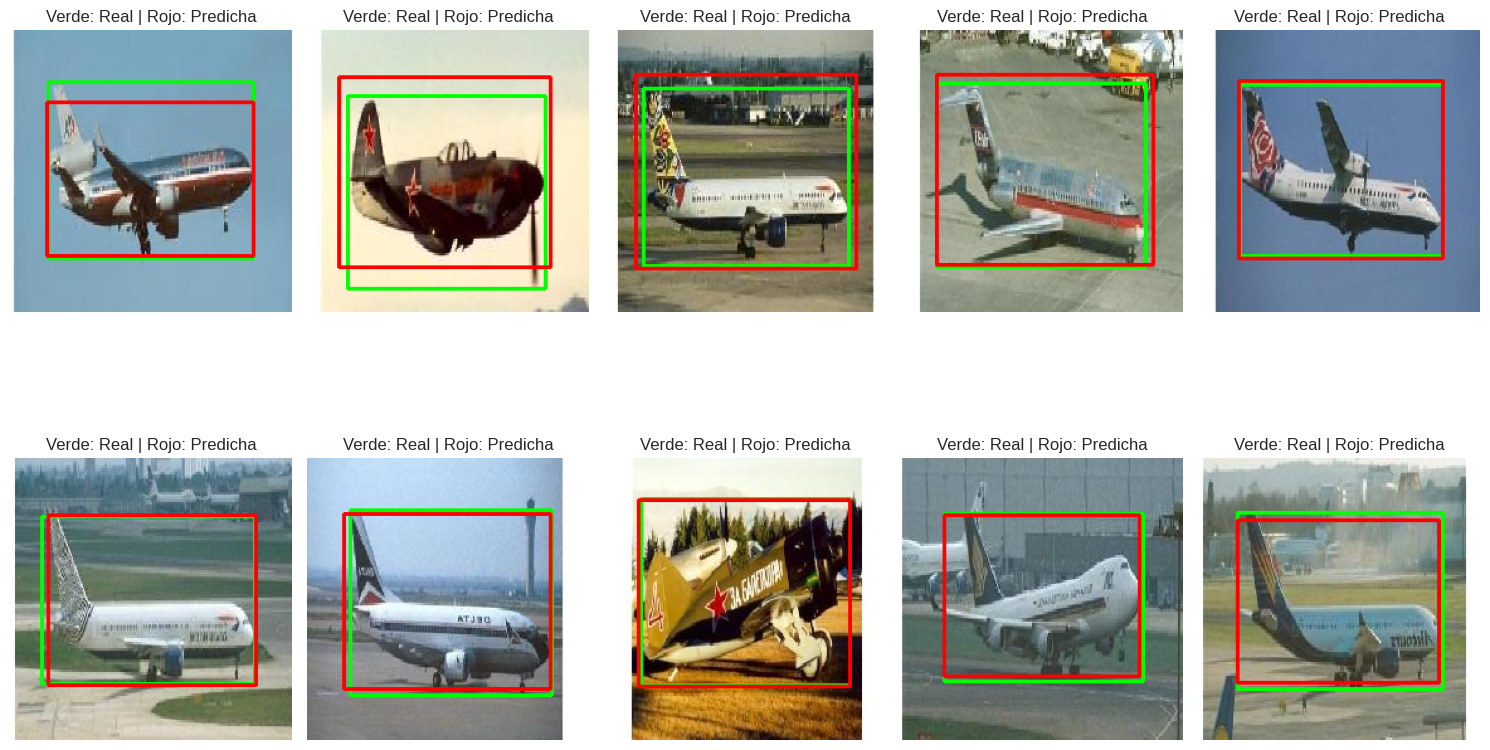

In [9]:
# %%
# ==========================================
# 9. Evaluación visual del modelo
# ==========================================
indices = np.random.choice(len(testX), size=10, replace=False)

plt.figure(figsize=(15, 10))
for i, idx in enumerate(indices):
    image_norm = testX[idx]
    true_box_norm = testY[idx]
    pred_box_norm = model.predict(np.expand_dims(image_norm, axis=0))[0]

    image_display = (image_norm * 255).astype(np.uint8)
    H, W, _ = image_display.shape

    # Coordenadas reales
    true_coords = [int(true_box_norm[0]*W), int(true_box_norm[1]*H),
                   int(true_box_norm[2]*W), int(true_box_norm[3]*H)]

    # Coordenadas predichas
    pred_coords = [int(pred_box_norm[0]*W), int(pred_box_norm[1]*H),
                   int(pred_box_norm[2]*W), int(pred_box_norm[3]*H)]

    output = image_display.copy()
    cv2.rectangle(output, (true_coords[0], true_coords[1]), (true_coords[2], true_coords[3]), (0,255,0), 2)
    cv2.rectangle(output, (pred_coords[0], pred_coords[1]), (pred_coords[2], pred_coords[3]), (255,0,0), 2)

    plt.subplot(2, 5, i + 1)
    plt.imshow(output)
    plt.title("Verde: Real | Rojo: Predicha")
    plt.axis("off")

plt.tight_layout()
plt.show()
